In [25]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import itertools
import random
import kagglehub
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [26]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [27]:
dataset_path = Path(kagglehub.dataset_download("jxwleong/coral-reef-dataset"))
csv_path = dataset_path / "combined_annotations_remapped.csv"

# Try common encodings
for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        print("✅ Loaded with encoding:", enc)
        break
    except UnicodeDecodeError:
        pass

df.head()


✅ Loaded with encoding: utf-8


,Name,Row,Column,Label,Unnamed: 4
0,i0201a.png,111,94,broken_coral_rubble,NaN
1,i0201a.png,173,243,broken_coral_rubble,NaN
2,i0201a.png,84,366,broken_coral_rubble,NaN
3,i0201a.png,54,802,broken_coral_rubble,NaN
4,i0201a.png,313,66,sand,NaN


In [28]:
print(df.columns)
print(df.head())
print(df["Label"].nunique())


Index(['Name', 'Row', 'Column', 'Label', 'Unnamed: 4'], dtype='object')
         Name  Row  Column                Label  Unnamed: 4
0  i0201a.png  111      94  broken_coral_rubble         NaN
1  i0201a.png  173     243  broken_coral_rubble         NaN
2  i0201a.png   84     366  broken_coral_rubble         NaN
3  i0201a.png   54     802  broken_coral_rubble         NaN
4  i0201a.png  313      66                 sand         NaN
40


In [29]:
# df is already loaded
df = df.drop(columns=["Unnamed: 4"], errors="ignore")

# normalize label text (keep underscores)
df["Label"] = df["Label"].astype(str).str.strip().str.lower()

print("Unique labels:", df["Label"].nunique())
print(df["Label"].value_counts().head(15))

Unique labels: 40
Label
crustose_coralline_algae    226017
turf                         43769
sand                         38880
porites                      35236
macroalgae                   23832
off                          13605
pocillopora                  11319
montipora                     8755
pavona                        5806
acropora                      3458
hard_substrate                2086
millepora                     1459
broken_coral_rubble           1025
montastraea                    645
leptastrea                     528
Name: count, dtype: int64


In [30]:
bad_labels = {"bad", "dark", "off", "unknown", "unlabeled", "background", "water"}
df = df[~df["Label"].isin(bad_labels)]

print("After removing invalid labels:")
print("Unique labels:", df["Label"].nunique())


After removing invalid labels:
Unique labels: 37


In [31]:
keep_labels = ["crustose_coralline_algae", "sand", "porites"]  # choose your own
df_top = df[df["Label"].isin(keep_labels)].copy()



In [32]:
image_labels = (
    df_top.groupby("Name")["Label"]
          .agg(lambda s: s.value_counts().idxmax())
          .reset_index()
          .rename(columns={"Name": "filename", "Label": "label"})
)

print("Image-level samples:")
print(image_labels.head())
print("Image-level class counts:")
print(image_labels["label"].value_counts())


Image-level samples:
     filename label
0  i0201a.png  sand
1  i0201d.png  sand
2  i0202b.png  sand
3  i0202d.png  sand
4  i0203a.png  sand
Image-level class counts:
label
crustose_coralline_algae    1647
sand                         338
porites                      237
Name: count, dtype: int64


In [33]:
def majority_ratio(s):
    return s.value_counts(normalize=True).iloc[0]

ratios = df_top.groupby("Name")["Label"].apply(majority_ratio).reset_index(name="majority_ratio")

image_labels = image_labels.merge(ratios, left_on="filename", right_on="Name", how="left").drop(columns=["Name"])

THRESH = 0.5
image_labels_clean = image_labels[image_labels["majority_ratio"] >= THRESH].drop(columns=["majority_ratio"])

print("Before filter:", len(image_labels), "After filter:", len(image_labels_clean))
print(image_labels_clean["label"].value_counts())


Before filter: 2222 After filter: 2177
label
crustose_coralline_algae    1634
sand                         327
porites                      216
Name: count, dtype: int64


In [34]:
print(dataset_path)


C:\Users\user\.cache\kagglehub\datasets\jxwleong\coral-reef-dataset\versions\2


In [35]:
dataset_path = Path(r"C:\Users\user\.cache\kagglehub\datasets\jxwleong\coral-reef-dataset\versions\2")

# Find all images
all_imgs = []
for ext in ("*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"):
    all_imgs += list(dataset_path.rglob(ext))

print("Total images found:", len(all_imgs))

# Map filename -> full path
img_map = {p.name: str(p) for p in all_imgs}

# Add full paths to your cleaned labels
final_df = image_labels_clean.copy()
final_df["filepath"] = final_df["filename"].map(img_map)

# Keep only matched files
final_df = final_df.dropna(subset=["filepath"]).reset_index(drop=True)

print("Matched labeled images:", len(final_df))
print(final_df.head())
print(final_df["label"].value_counts())


Total images found: 9010
Matched labeled images: 2177
     filename label                                           filepath
0  i0201a.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
1  i0201d.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
2  i0202b.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
3  i0202d.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
4  i0203a.png  sand  C:\Users\user\.cache\kagglehub\datasets\jxwleo...
label
crustose_coralline_algae    1634
sand                         327
porites                      216
Name: count, dtype: int64


In [36]:
train_df, temp_df = train_test_split(
    final_df, test_size=0.2, random_state=42, stratify=final_df["label"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df["label"].value_counts())


Train: 1741 Val: 218 Test: 218
label
crustose_coralline_algae    1307
sand                         261
porites                      173
Name: count, dtype: int64


In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)


max_n = train_df["label"].value_counts().max()


train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


val_gen = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
num_classes = len(train_gen.class_indices)


Found 1741 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Found 218 validated image filenames belonging to 3 classes.
Class indices: {'crustose_coralline_algae': 0, 'porites': 1, 'sand': 2}


In [38]:
class_names = list(test_gen.class_indices.keys())
num_classes = len(class_names)


In [39]:
classes = np.array(sorted(train_df["label"].unique()))

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)

class_weight_dict = dict(zip(classes, weights))
print(class_weight_dict)

{np.str_('crustose_coralline_algae'): np.float64(0.4440193828105075), np.str_('porites'): np.float64(3.3545279383429674), np.str_('sand'): np.float64(2.2234993614303957)}


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224)
num_classes = len(train_gen.class_indices)

# Augmentation inside the model (only active during training)
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="augment")

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = data_augment(inputs)
x = layers.Rescaling(1./255)(x)

# Block 1
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 2
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 3
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 4 (still lightweight)
x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

custom_cnn = Model(inputs, outputs, name="CustomLightCNN")

custom_cnn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

custom_cnn.summary()


Model: "CustomLightCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [41]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6),
    ModelCheckpoint("vgg19_best.keras", monitor="val_loss", save_best_only=True),
]

history_custom = custom_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks,
    # class_weight=class_weight_dict  # enable only if not oversampling
)


Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7507 - loss: 0.6580 - val_accuracy: 0.1009 - val_loss: 2.1887 - learning_rate: 0.0010
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8150 - loss: 0.5029 - val_accuracy: 0.1009 - val_loss: 2.5901 - learning_rate: 0.0010
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8122 - loss: 0.4628 - val_accuracy: 0.1009 - val_loss: 2.6129 - learning_rate: 0.0010
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8334 - loss: 0.4198 - val_accuracy: 0.1514 - val_loss: 2.2865 - learning_rate: 3.0000e-04
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8610 - loss: 0.3743 - val_accuracy: 0.1514 - val_loss: 2.3736 - learning_rate: 3.0000e-04


In [42]:
pred_probs = custom_cnn.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
                          precision    recall  f1-score   support

crustose_coralline_algae       0.00      0.00      0.00       164
                 porites       0.10      1.00      0.18        21
                    sand       0.00      0.00      0.00        33

                accuracy                           0.10       218
               macro avg       0.03      0.33      0.06       218
            weighted avg       0.01      0.10      0.02       218

Confusion Matrix:
 [[  0 164   0]
 [  0  21   0]
 [  0  33   0]]


c:\codes\Classfication of coral reef\-IMAGE-CLASSIFICATION-FOR-SOCIAL-AND-ENVIRONMENTAL-IMPACT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\codes\Classfication of coral reef\-IMAGE-CLASSIFICATION-FOR-SOCIAL-AND-ENVIRONMENTAL-IMPACT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\codes\Classfication of coral reef\-IMAGE-CLASSIFICATION-FOR-SOCIAL-AND-ENVIRONMENTAL-IMPACT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill

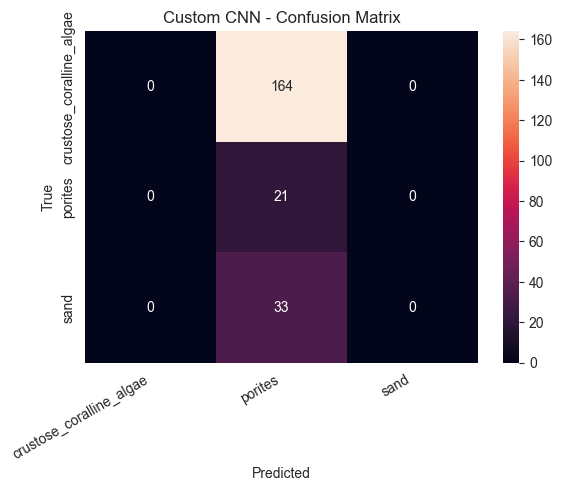

In [43]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Custom CNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

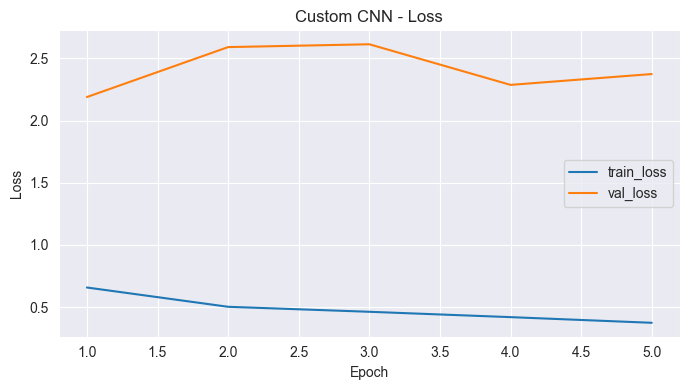

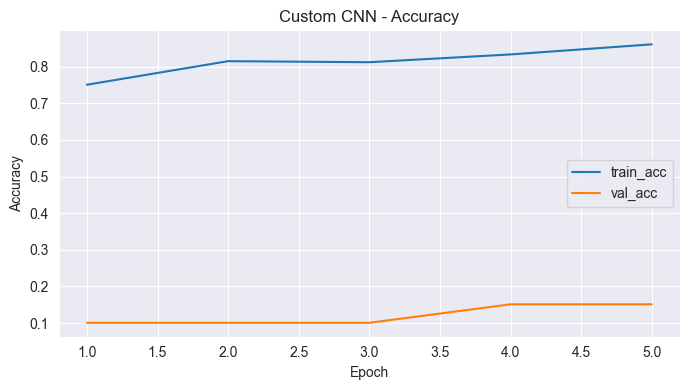

In [44]:
def plot_history(hist, title="Training Curves"):
    h = hist.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, h["loss"], label="train_loss")
    plt.plot(epochs, h["val_loss"], label="val_loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, h["accuracy"], label="train_acc")
    plt.plot(epochs, h["val_accuracy"], label="val_acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_custom, title="Custom CNN")

C:\Users\user\AppData\Local\Temp\ipykernel_1832\2863514849.py:58: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_1832\2863514849.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\codes\Classfication of coral reef\-IMAGE-CLASSIFICATION-FOR-SOCIAL-AND-ENVIRONMENTAL-IMPACT\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\codes\Classfication of coral reef\-IMAGE-CLASSIFICATION-FOR-SOCIAL-AND-ENVIRONMENTAL-IMPACT\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


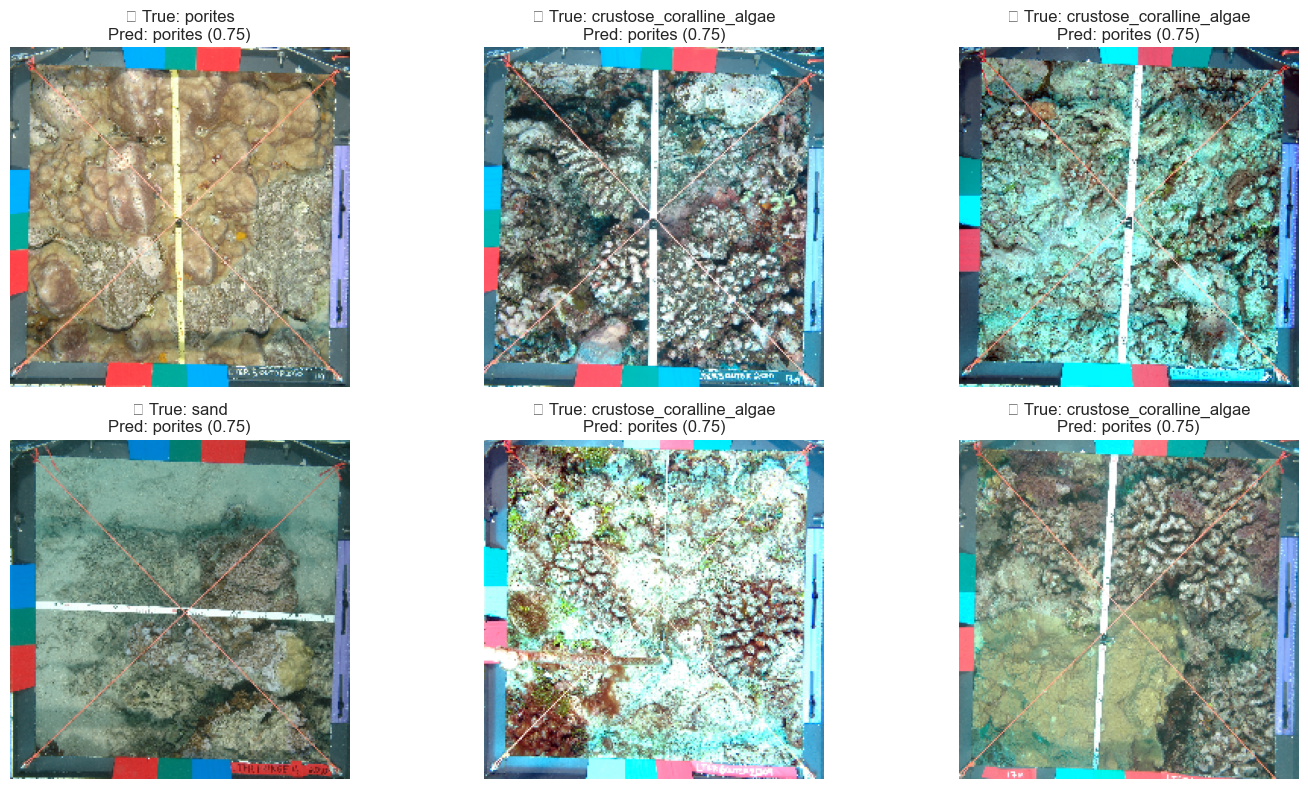

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


class_names = list(train_gen.class_indices.keys())   

def predict_and_show(
    model,
    df,
    n=6,
    target_size=(224,224),
    mode="random",          # "random" | "random_new_each_run" | "fixed_seed"
    seed=42,                # used only if mode="fixed_seed"
    show_seed=False,
    max_cols=3
):
    df = df.dropna(subset=["filepath", "label"]).reset_index(drop=True)

    if mode == "fixed_seed":
        sample = df.sample(n=min(n, len(df)), random_state=seed).reset_index(drop=True)
        used_seed = seed
    elif mode == "random_new_each_run":
        used_seed = int(np.random.randint(0, 1_000_000))
        sample = df.sample(n=min(n, len(df)), random_state=used_seed).reset_index(drop=True)
    else:  # "random"
        used_seed = None
        sample = df.sample(n=min(n, len(df))).reset_index(drop=True)

    if show_seed and used_seed is not None:
        print("Sample seed:", used_seed)

    cols = min(max_cols, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i in range(len(sample)):
        img_path = sample.loc[i, "filepath"]
        true_label = sample.loc[i, "label"]

        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)

        probs = model.predict(x, verbose=0)[0]
        pred_idx = int(np.argmax(probs))
        pred_label = class_names[pred_idx]
        conf = float(probs[pred_idx])

        ok = (str(true_label).strip() == str(pred_label).strip())
        status = "✅" if ok else "❌"

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{status} True: {true_label}\nPred: {pred_label} ({conf:.2f})")

    plt.tight_layout()
    plt.show()



predict_and_show(custom_cnn, test_df, n=6, target_size=(224,224), mode="random")



In [46]:
print("Custom CNN params:", custom_cnn.count_params())

Custom CNN params: 423619
